<a href="https://colab.research.google.com/github/trilgar/AFED/blob/main/random_forest_AFED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Підготовка даних

In [55]:
test = pd.read_csv('/content/drive/MyDrive/group project dataset/one_hot_test.csv', index_col=0)
train = pd.read_csv('/content/drive/MyDrive/group project dataset/one_hot_train.csv', index_col = 0)
test_Y = test.SalePrice
train_Y = train.SalePrice
test = test.drop(['SalePrice'], axis=1)
train = train.drop(['SalePrice'], axis=1)
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [56]:
test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,...,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,554.294925,1046.117970,1156.534613,325.967786,3.543523,1486.045922,0.434454,0.065202,1.570939,0.377656,2.854010,1.042495,6.385195,0.58122,1977.721217,1.766118,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705,0.010281,0.05072,0.006854,0.763537,...,0.028101,0.249486,0.017820,0.191227,0.011652,0.584647,0.011652,0.067169,0.004112,0.268677,0.251542,0.266621,0.428376,0.000685,0.026731,0.004112,0.004798,0.910212,0.086361,0.021933,0.891707,0.040439,0.039753,0.117889,0.000685,0.030158,0.005483,0.002056,0.011652,0.002742,0.002056,0.080192,0.002742,0.862234,0.061001,0.005483,0.008225,0.017820,0.825223,0.082248
std,42.746880,20.561228,4955.517327,1.436812,1.113740,30.390071,21.130467,176.709824,455.111888,176.693301,437.110508,442.746712,398.165820,420.610226,44.043251,485.566099,0.530283,0.252295,0.555190,0.503017,0.829788,0.208472,1.508895,0.64742,25.714451,0.775679,216.974165,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740,0.100907,0.21950,0.082533,0.425056,...,0.165319,0.432864,0.132344,0.393402,0.107350,0.492952,0.107350,0.250401,0.064018,0.443424,0.434048,0.442344,0.495013,0.026180,0.161350,0.064018,0.069124,0.285975,0.280992,0.146514,0.310857,0.197053,0.195446,0.322587,0.026180,0.171080,0.073871,0.045314,0.107350,0.052306,0.045314,0.271683,0.052306,0.344772,0.239414,0.073871,0.090348,0.132344,0.379907,0.274837
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,

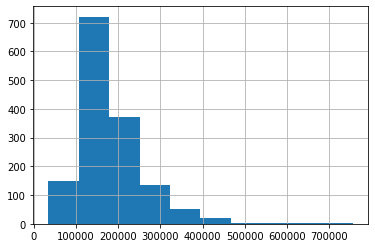

In [57]:
train_Y.hist()

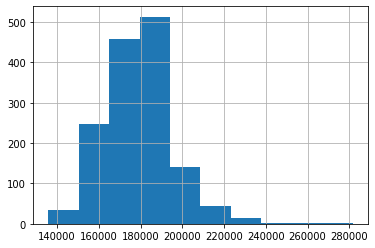

In [58]:
test_Y.hist()

## Функція для визначення точності моделі


In [59]:
def calculate_accuracy(model, test_X, test_Y):
  predicted = model.predict(test_X)

  plt.figure(figsize=(8, 4))
  plt.title('predicted sale price')
  plt.plot(predicted, label = 'predicted', color = 'blue')
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.title('real sale price')
  plt.plot(test_Y, label = 'real', color = 'green')
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.title('prediction error')
  plt.plot(np.abs(predicted - test_Y), label = 'error', color = 'red')
  plt.show()
  return mean_absolute_error(predicted, test_Y), mean_absolute_percentage_error(predicted, test_Y)

## Дерево рішень

In [60]:
tc = DecisionTreeRegressor(random_state=1)
tc.fit(train, train_Y)

DecisionTreeRegressor(random_state=1)

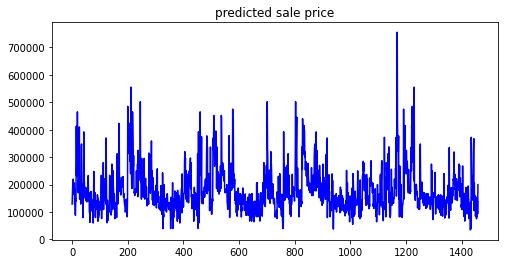

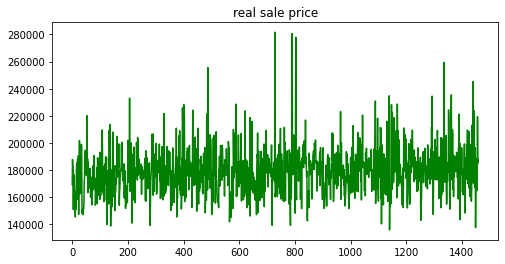

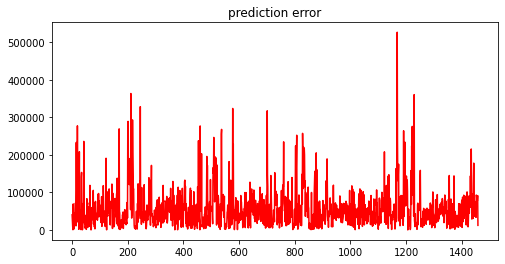

(56719.374119439104, 0.3641191327158986)

In [61]:
calculate_accuracy(tc, test, test_Y)


## Random forest без налаштувань

In [62]:
rf = RandomForestRegressor(random_state=1)

In [63]:
rf.fit(train, train_Y)

RandomForestRegressor(random_state=1)

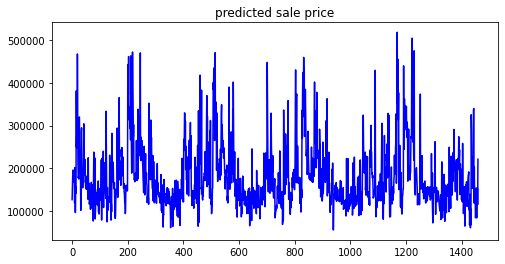

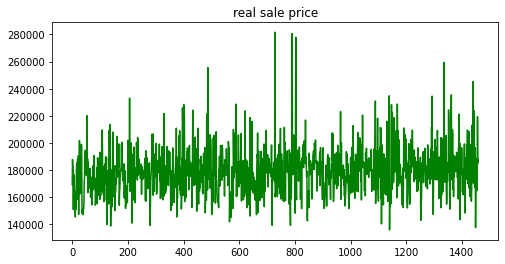

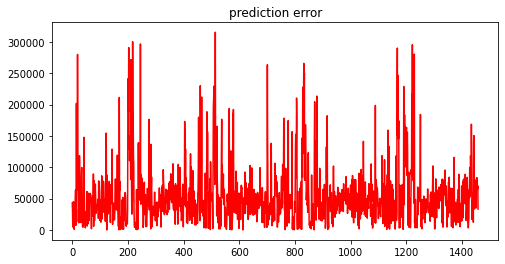

(53701.34742618553, 0.32094973633471924)

In [64]:
calculate_accuracy(rf, test, test_Y)

Як бачимо, з результатів тестування верзультати не дуже хороші

## Спроба зміни навчальної вибірки

спробуємо взяти тільки деякі з характеристик та спрогнозувати за ними

In [65]:
test_X = pd.read_csv('/content/drive/MyDrive/group project dataset/test.csv', index_col=0)
train_X = pd.read_csv('/content/drive/MyDrive/group project dataset/train.csv', index_col=0)
test_Y = pd.read_csv('/content/drive/MyDrive/group project dataset/sample_submission.csv', index_col=0)
train_Y = train_X.SalePrice

In [66]:
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

In [67]:
test_X = test_X[features]

train_X = train_X[features]

In [68]:
rf_short = RandomForestRegressor(random_state=1)

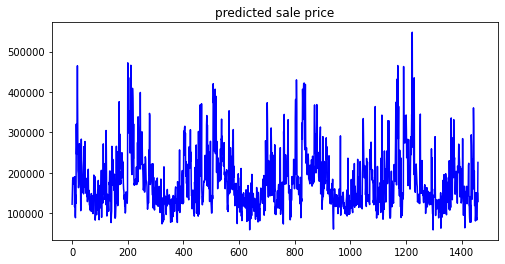

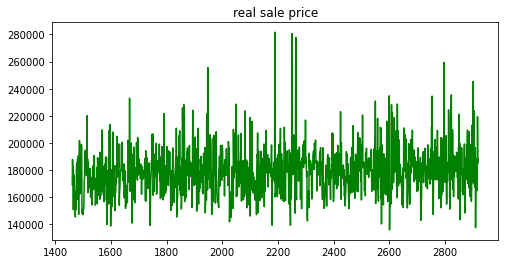

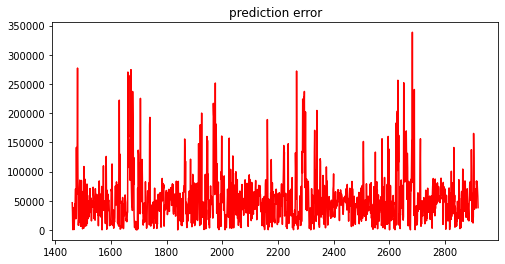

(51627.076451747445, 0.3103992536902496)

In [69]:
rf.fit(train_X, train_Y)
calculate_accuracy(rf, test_X, test_Y.SalePrice)

Як бачимо якість моделі покращилась, тобто деякі колонки в датасеті погіршують якість моделі. Вищевказана конфігурація була вибрана підбором як найкраща.

## Підбір гіперпараметрів

In [70]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=40, n_jobs = -1, scoring="neg_mean_squared_error", return_train_score=True)

In [71]:
rf_random.fit(train_X, train_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [130, 180, 230]},
                   random_state=40, return_train_score=True,
                   scoring='neg_mean_squared_error', verbose=2)

In [72]:
cv_results = pd.DataFrame(rf_random.cv_results_)
cv_results[['param_n_estimators', 'param_min_samples_split','param_min_samples_leaf', 'param_max_features', 'param_max_depth', 'param_bootstrap', 'mean_train_score']]

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_train_score
0,130,10,4,sqrt,10,False,-6.356786e+08
1,230,10,2,sqrt,20,False,-3.989252e+08
2,180,2,2,sqrt,30,False,-1.816210e+08
3,180,2,1,sqrt,10,True,-3.128926e+08
4,180,10,2,sqrt,90,False,-3.989046e+08
...,...,...,...,...,...,...,...
95,130,5,2,sqrt,90,False,-2.165179e+08
96,230,10,1,auto,None,True,-4.562052e+08
97,180,2,1,auto,60,True,-1.838301e+08
98,180,2,4,sqrt,50,True,-8.654743e+08


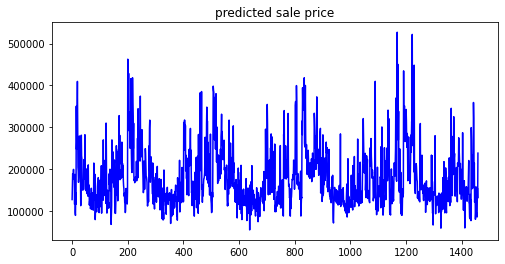

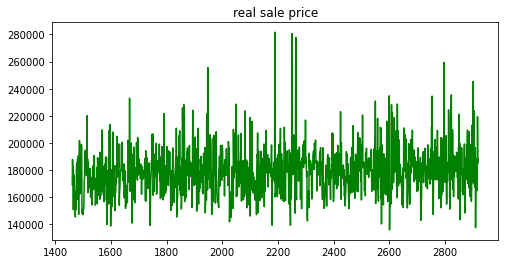

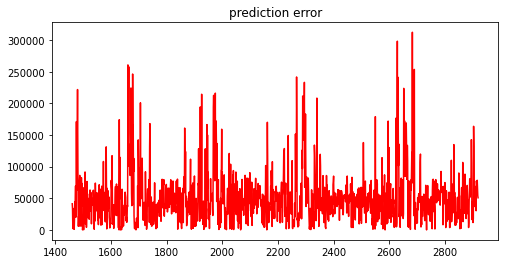

(50010.798888599755, 0.2978683191322767)

In [73]:
calculate_accuracy(rf_random, test_X, test_Y.SalePrice)

## Зміна пропорцій тестової та тренувальної вибірки

In [74]:
test = pd.read_csv('/content/drive/MyDrive/group project dataset/test.csv', index_col=0)
train = pd.read_csv('/content/drive/MyDrive/group project dataset/train.csv', index_col=0)
test["SalePrice"] = pd.read_csv('/content/drive/MyDrive/group project dataset/sample_submission.csv', index_col=0)
train
dataset = pd.concat([test, train], axis=0, ignore_index=True)
dataset = dataset[features + ['SalePrice']]

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,SalePrice
0,11622,1961,896,0,1,2,5,169277.052498
1,14267,1958,1329,0,1,3,6,187758.393989
2,13830,1997,928,701,2,3,6,183583.683570
3,9978,1998,926,678,2,3,7,179317.477511
4,5005,1992,1280,0,2,2,5,150730.079977
...,...,...,...,...,...,...,...,...
2914,7917,1999,953,694,2,3,7,175000.000000
2915,13175,1978,2073,0,2,3,7,210000.000000
2916,9042,1941,1188,1152,2,4,9,266500.000000
2917,9717,1950,1078,0,1,2,5,142125.000000


In [75]:
def part_dataset(train_percentage, dataset):
  train = dataset.sample(frac = train_percentage/100)
  test = dataset.drop(train.index)
  train_Y = train.SalePrice
  train_X = train.drop('SalePrice', axis = 1)
  test_Y = test.SalePrice
  test_X = test.drop('SalePrice', axis = 1)
  return train_X, train_Y, test_X, test_Y 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


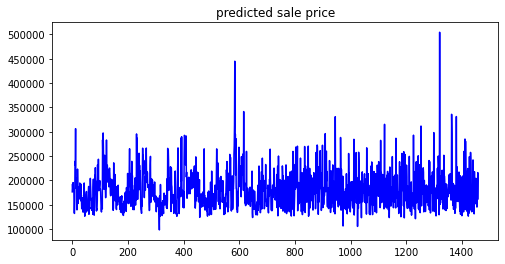

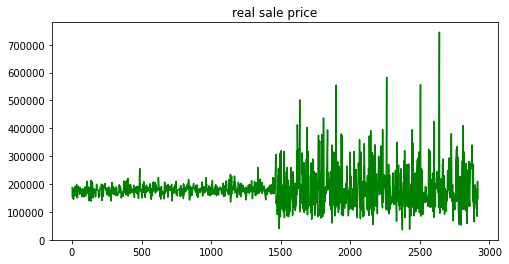

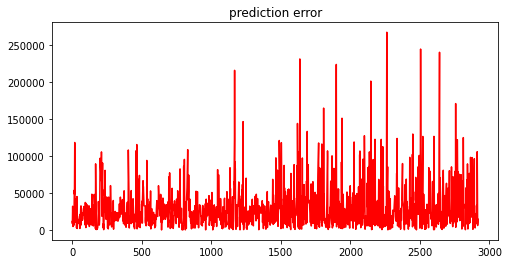

Fitting 3 folds for each of 100 candidates, totalling 300 fits


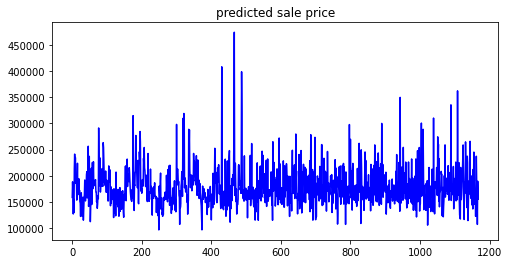

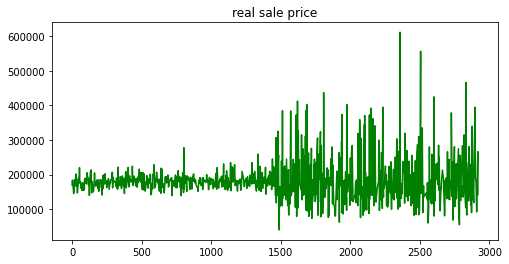

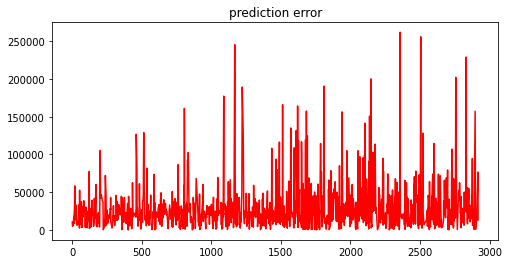

Fitting 3 folds for each of 100 candidates, totalling 300 fits


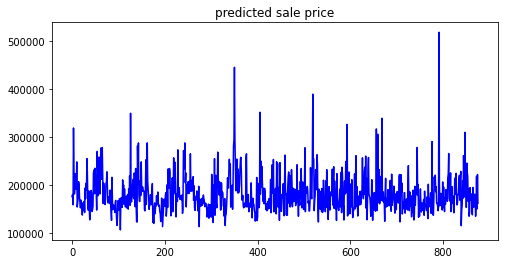

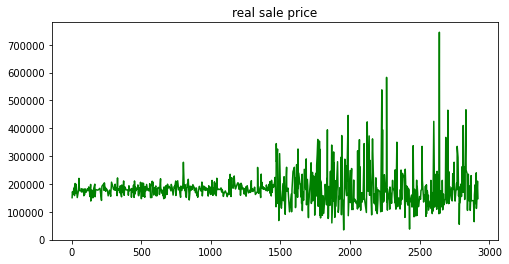

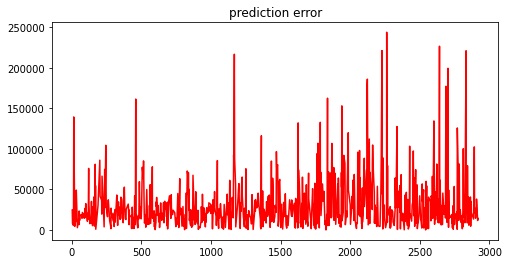

Fitting 3 folds for each of 100 candidates, totalling 300 fits


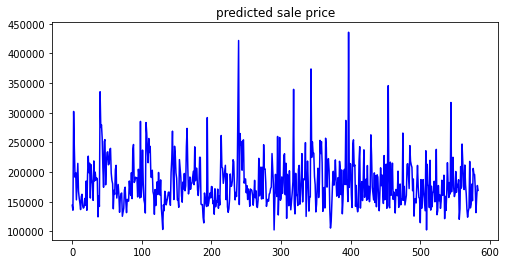

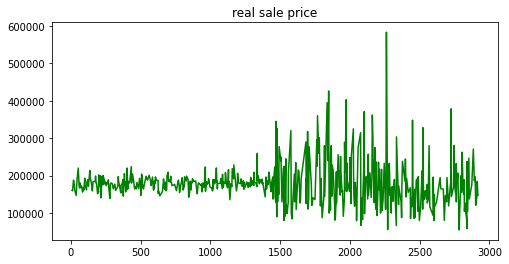

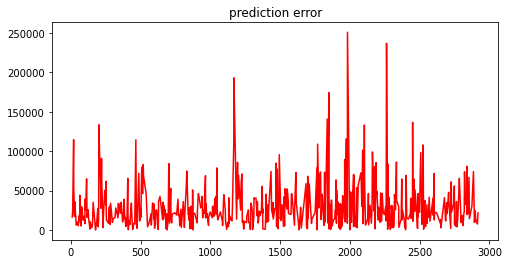

Fitting 3 folds for each of 100 candidates, totalling 300 fits


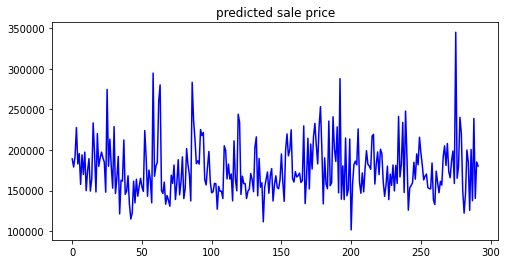

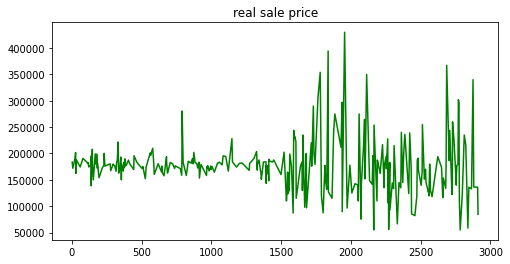

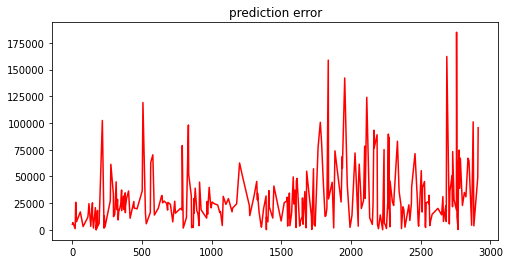

Fitting 3 folds for each of 100 candidates, totalling 300 fits


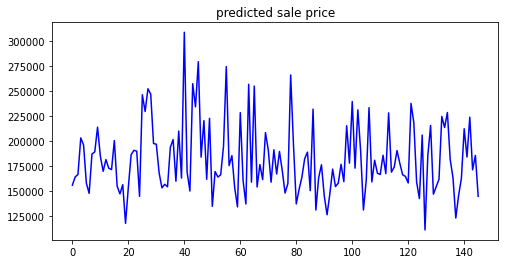

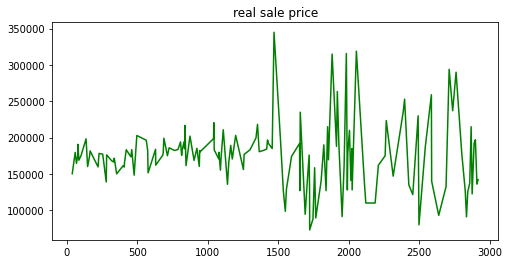

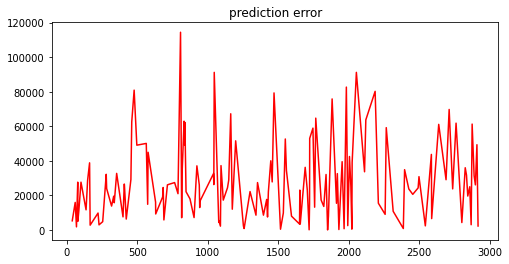

In [78]:
mean_abs_error = []
mean_abs_perc_error = []
for percent in [50, 60, 70, 80, 90, 95]:
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=40, n_jobs = -1, scoring="neg_mean_squared_error", return_train_score=True)
  train_X, train_Y, test_X, test_Y  = part_dataset(percent, dataset)
  rf_random.fit(train_X, train_Y)
  mae, mape = calculate_accuracy(rf_random, test_X, test_Y)
  mean_abs_error.append(mae)
  mean_abs_perc_error.append(mape)

In [81]:
pd.DataFrame(data = {'MAE': mean_abs_error, 'MAPE': mean_abs_perc_error}, index = ['50% : 50%', '60% : 40%', '70% : 30%', '80% : 20%', '90% : 10%', '95% : 5%'])

,MAE,MAPE
50% : 50%,29022.395444,0.157576
60% : 40%,28717.937419,0.157254
70% : 30%,29708.192980,0.158485
80% : 20%,29388.339818,0.157800
90% : 10%,29466.289440,0.165012
95% : 5%,27423.659941,0.149045
